In [1]:
import numpy as np
import pandas as pd
pd.pandas.set_option('display.max_columns', None)
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.compose import make_column_transformer
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.multioutput import MultiOutputClassifier
from sklearn.model_selection import train_test_split, cross_val_score, cross_validate, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import roc_auc_score, roc_curve
import joblib

In [2]:
features = pd.read_csv('data/training_set_features.csv', index_col="respondent_id")

In [3]:
label = pd.read_csv('data/training_set_labels.csv', index_col="respondent_id")

In [4]:
df = features.merge(label, on='respondent_id', how='inner')

df.head()

,h1n1_concern,h1n1_knowledge,behavioral_antiviral_meds,behavioral_avoidance,behavioral_face_mask,behavioral_wash_hands,behavioral_large_gatherings,behavioral_outside_home,behavioral_touch_face,doctor_recc_h1n1,doctor_recc_seasonal,chronic_med_condition,child_under_6_months,health_worker,health_insurance,opinion_h1n1_vacc_effective,opinion_h1n1_risk,opinion_h1n1_sick_from_vacc,opinion_seas_vacc_effective,opinion_seas_risk,opinion_seas_sick_from_vacc,age_group,education,race,sex,income_poverty,marital_status,rent_or_own,employment_status,hhs_geo_region,census_msa,household_adults,household_children,employment_industry,employment_occupation,h1n1_vaccine,seasonal_vaccine
respondent_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,3.0,1.0,2.0,2.0,1.0,2.0,55 - 64 Years,< 12 Years,White,Female,Below Poverty,Not Married,Own,Not in Labor Force,oxchjgsf,Non-MSA,0.0,0.0,NaN,NaN,0,0
1,3.0,2.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,5.0,4.0,4.0,4.0,2.0,4.0,35 - 44 Years,12 Years,White,Male,Below Poverty,Not Married,Rent,Employed,bhuqouqj,"MSA, Not Principle City",0.0,0.0,pxcmvdjn,xgwztkwe,0,1
2,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,1.0,0.0,0.0,NaN,3.0,1.0,1.0,4.0,1.0,2.0,18 - 34 Years,College Graduate,White,Male,"<= $75,000, Above Poverty",Not Married,Own,Employed,qufhixun,"MSA, Not Principle City",2.0,0.0,rucpziij,xtkaffoo,0,0
3,1.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,NaN,3.0,3.0,5.0,5.0,4.0,1.0,65+ Years,12 Years,White,Female,Below Poverty,Not Married,Rent,Not in Labor Force,lrircsnp,"MSA, Principle City",0.0,0.0,NaN,NaN,0,1
4,2.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,NaN,3.0,3.0,2.0,3.0,1.0,4.0,45 - 54 Years,Some College,White,Female,"<= $75,000, Above Poverty",Married,Own,Employed,qufhixun,"MSA, Not Principle City",1.0,0.0,wxleyezf,emcorrxb,0,0


In [5]:
def df_summary(df):
    
    print(f"Dataset Shape: {df.shape}")
    
    summary = pd.DataFrame(df.dtypes, columns=['dtypes'])
    
    summary = summary.reset_index()
    
    summary['Name'] = summary['index']
    
    summary = summary[['Name','dtypes']]
    
    summary['Uniques'] = df.nunique().values
    
    summary['Missing Count'] = df.isnull().sum().values
    
    summary['Missing Percentage'] = df.isnull().sum().values/len(df)
    
    summary['Missing Percentage'] = summary['Missing Percentage'].map("{:.2%}".format)
    
    for name in summary['Name'].value_counts().index:
        
        summary.loc[summary['Name'] == name, 'Entropy'] = round(stats.entropy(df[name].value_counts(normalize=True), base=2),2) 

    return summary

In [6]:
df_summary(df)

Dataset Shape: (26707, 37)


,Name,dtypes,Uniques,Missing Count,Missing Percentage,Entropy
0,h1n1_concern,float64,4,92,0.34%,1.86
1,h1n1_knowledge,float64,3,116,0.43%,1.33
2,behavioral_antiviral_meds,float64,2,71,0.27%,0.28
3,behavioral_avoidance,float64,2,208,0.78%,0.85
4,behavioral_face_mask,float64,2,19,0.07%,0.36
5,behavioral_wash_hands,float64,2,42,0.16%,0.67
6,behavioral_large_gatherings,float64,2,87,0.33%,0.94
7,behavioral_outside_home,float64,2,82,0.31%,0.92
8,behavioral_touch_face,float64,2,128,0.48%,0.91
9,doctor_recc_h1n1,float64,2,2160,8.09%,0.76


In [7]:
X_num_cols = [var for var in df.columns if df[var].dtype != 'O' and var not in ['h1n1_vaccine', 'seasonal_vaccine']]

In [8]:
X_cat_cols = [var for var in df.columns if df[var].dtype == 'O' and var not in ['h1n1_vaccine', 'seasonal_vaccine']]

In [9]:
X_cols = [var for var in df.columns if var not in ['h1n1_vaccine', 'seasonal_vaccine']]
X = df[X_cols]

In [10]:
y_cols = ['h1n1_vaccine', 'seasonal_vaccine']
y = df[y_cols]

In [11]:
# Categorical features

In [12]:
imp_cat = SimpleImputer(strategy='constant', fill_value='missing')
ohe = OneHotEncoder(handle_unknown='ignore')

In [13]:
pipe_cat = make_pipeline(imp_cat, ohe)

In [14]:
# Numeric features

In [15]:
imp_num = SimpleImputer(strategy='median')

In [16]:
ct = make_column_transformer(
    (pipe_cat, X_cat_cols),
    (imp_num, X_num_cols),
    remainder='passthrough')

In [17]:
# Testing multiple models for a baseline score

LR: AUC = 0.8437 ± 0.004038
KN: AUC = 0.7222 ± 0.003534
DT: AUC = 0.6646 ± 0.004514
RF: AUC = 0.8375 ± 0.005064
GB: AUC = 0.8484 ± 0.005207
AB: AUC = 0.8442 ± 0.004741


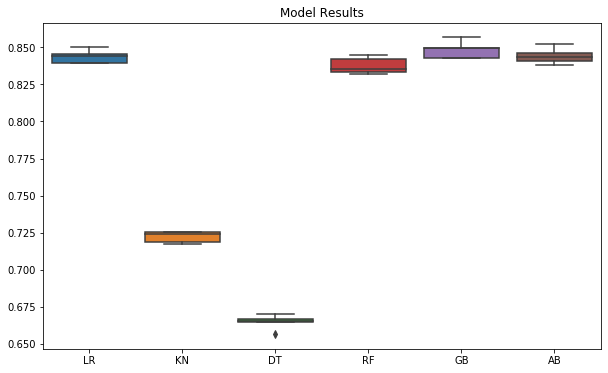

In [18]:
models = []
models.append(('LR', LogisticRegression(solver='liblinear', random_state=123)))
models.append(('KN', KNeighborsClassifier(n_neighbors=3)))
models.append(('DT', DecisionTreeClassifier(random_state=123)))
models.append(('RF', RandomForestClassifier(random_state=123)))
models.append(('GB', GradientBoostingClassifier(random_state=123)))
models.append(('AB', AdaBoostClassifier(random_state=123)))


results = []
names = []
for name, model in models:
    pipe = make_pipeline(ct, MultiOutputClassifier(model))
    cv_results = cross_val_score(pipe, X, y, cv=5, scoring='roc_auc') 
    results.append(cv_results)
    names.append(name)
    msg = "{}: AUC = {:.4} \u00B1 {:.4}".format(name , cv_results.mean(), cv_results.std())
    print(msg)

plt.figure(figsize=(10,6))
sns.boxplot(names, results)
plt.title('Model Results')
plt.show()

In [19]:
# estimator = LogisticRegression(solver='liblinear', penalty="l1", C=1, max_iter=1000, random_state=123)

In [20]:
# estimator = RandomForestClassifier(n_estimators=200, min_samples_split=4, min_samples_leaf=5,max_features='sqrt',
#                                    max_depth=20, bootstrap=False, random_state=123)

In [21]:
estimator = GradientBoostingClassifier(random_state=123)

In [22]:
estimators = MultiOutputClassifier(estimator)

In [23]:
pipe = make_pipeline(ct, estimators)

In [24]:
# Grid Search

In [25]:
params = {}

# Pre-processing params
params['columntransformer__pipeline__simpleimputer__add_indicator'] = [False, True]
params['columntransformer__simpleimputer__add_indicator'] = [False, True]

# LR params
# params['multioutputclassifier__estimator__penalty'] = ['l1', 'l2']
# params['multioutputclassifier__estimator__C'] = [0.1, 1, 10]

# RF params
# params["multioutputclassifier__estimator__bootstrap"] = [True, False]
# params["multioutputclassifier__estimator__max_features"] = [None, 'sqrt', 'log2']
# params["multioutputclassifier__estimator__max_depth"] = [2, 5, 10, 20, 30]
# params["multioutputclassifier__estimator__min_samples_leaf"] = [1, 5, 10]
# params["multioutputclassifier__estimator__min_samples_split"] = [2, 4, 8, 10, 12]
# params["multioutputclassifier__estimator__n_estimators"] = [100, 200, 500]

# GB params
params["multioutputclassifier__estimator__max_features"] = [None, 'sqrt', 'log2']
params["multioutputclassifier__estimator__max_depth"] = [2, 5, 10, 20, 30]
params["multioutputclassifier__estimator__min_samples_leaf"] = [1, 5, 10]
params["multioutputclassifier__estimator__min_samples_split"] = [2, 4, 8, 10, 12]
params["multioutputclassifier__estimator__n_estimators"] = [100, 200, 500]

In [26]:
grid = RandomizedSearchCV(pipe, params, cv=5, scoring='roc_auc', random_state=123)
grid.fit(X, y);

In [27]:
results = pd.DataFrame(grid.cv_results_)
results.sort_values('rank_test_score').head(10)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_multioutputclassifier__estimator__n_estimators,param_multioutputclassifier__estimator__min_samples_split,param_multioutputclassifier__estimator__min_samples_leaf,param_multioutputclassifier__estimator__max_features,param_multioutputclassifier__estimator__max_depth,param_columntransformer__simpleimputer__add_indicator,param_columntransformer__pipeline__simpleimputer__add_indicator,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
8,37.713094,0.118299,0.072817,0.000400,200,2,1,None,5,True,True,{'multioutputclassifier__estimator__n_estimato...,0.863492,0.862047,0.862511,0.872047,0.861590,0.864337,0.003906,1
4,38.008361,0.205339,0.235653,0.001357,200,8,5,sqrt,20,True,False,{'multioutputclassifier__estimator__n_estimato...,0.853974,0.852892,0.852932,0.862491,0.853479,0.855153,0.003690,2
9,23.019385,0.029492,0.233252,0.000748,200,2,10,log2,30,True,True,{'multioutputclassifier__estimator__n_estimato...,0.851403,0.850580,0.854107,0.860845,0.850231,0.853433,0.003947,3
0,57.207685,0.170754,0.515516,0.001020,500,10,10,log2,30,True,False,{'multioutputclassifier__estimator__n_estimato...,0.851723,0.850090,0.853053,0.861538,0.849510,0.853183,0.004359,4
1,55.052999,0.080020,0.123628,0.000490,100,12,10,None,20,True,False,{'multioutputclassifier__estimator__n_estimato...,0.848148,0.847677,0.842856,0.855517,0.846407,0.848121,0.004137,5
3,1.055638,0.008454,0.041809,0.000400,100,10,10,log2,2,True,True,{'multioutputclassifier__estimator__n_estimato...,0.846234,0.840076,0.847103,0.850283,0.839200,0.844579,0.004263,6
5,1.755195,0.005270,0.050611,0.000800,100,4,5,log2,5,False,True,{'multioutputclassifier__estimator__n_estimato...,0.843823,0.840426,0.845953,0.853286,0.839258,0.844549,0.004977,7
7,0.838989,0.004070,0.031407,0.000800,100,8,1,log2,2,False,False,{'multioutputclassifier__estimator__n_estimato...,0.837501,0.829724,0.839842,0.844609,0.831585,0.836652,0.005438,8
2,94.835760,0.944039,0.193044,0.002192,500,10,1,None,20,False,True,{'multioutputclassifier__estimator__n_estimato...,0.824875,0.825281,0.829567,0.838172,0.824514,0.828482,0.005178,9
6,73.504755,0.106747,0.149834,0.000748,100,8,1,None,20,False,True,{'multioutputclassifier__estimator__n_estimato...,0.821972,0.822669,0.828886,0.836850,0.821050,0.826285,0.005958,10


In [28]:
print(F"Grid best score: {grid.best_score_}")
print('')
print(F"Grid best score: {grid.best_params_}")

Grid best score: 0.8643373505031076

Grid best score: {'multioutputclassifier__estimator__n_estimators': 200, 'multioutputclassifier__estimator__min_samples_split': 2, 'multioutputclassifier__estimator__min_samples_leaf': 1, 'multioutputclassifier__estimator__max_features': None, 'multioutputclassifier__estimator__max_depth': 5, 'columntransformer__simpleimputer__add_indicator': True, 'columntransformer__pipeline__simpleimputer__add_indicator': True}


In [29]:
joblib.dump(grid.best_estimator_, 'joblib/grid_best_gb.joblib')

['joblib/grid_best_gb.joblib']

In [30]:
test_features_df = pd.read_csv('data/test_set_features.csv', index_col="respondent_id")

In [31]:
test_probas = grid.predict_proba(test_features_df)

In [32]:
submission_df = pd.read_csv('data/submission_format.csv', index_col="respondent_id")

In [33]:
submission_df.head()

,h1n1_vaccine,seasonal_vaccine
respondent_id,,
26707,0.5,0.7
26708,0.5,0.7
26709,0.5,0.7
26710,0.5,0.7
26711,0.5,0.7


In [34]:
# Make sure we have the rows in the same order
np.testing.assert_array_equal(test_features_df.index.values, submission_df.index.values)

# Save predictions to submission data frame
submission_df["h1n1_vaccine"] = test_probas[0][:, 1]
submission_df["seasonal_vaccine"] = test_probas[1][:, 1]

submission_df.head()

,h1n1_vaccine,seasonal_vaccine
respondent_id,,
26707,0.091345,0.194496
26708,0.045204,0.031655
26709,0.121887,0.666496
26710,0.702488,0.904082
26711,0.266596,0.504416


In [35]:
submission_df.to_csv('results/20200503_submission_gb.csv', index=True)